# User requests clustering by Dmitriy Milevich
## Into
For clusterisation I decided to use Latent Derichlet Allocation approach for topic modelling. There are many other approaches that can be fruitful in this case, e.g. KNN clustering on word embeddings. However, for relatively small size of dataset and demonstration purposes this one will suffice.

In [1]:
from pymystem3 import Mystem
from nltk.corpus import stopwords
from string import punctuation
import gensim
from gensim.corpora.dictionary import Dictionary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
f = open("dataset.txt", "r")
lines = f.readlines()

First we do lemmatisation and removal of words that are not rich in meaning

In [3]:
mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

def lemmatize_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    return tokens

In [4]:
texts = []
for line in lines:
    texts.append(" ".join(lemmatize_text(line)))

In [5]:
print(f'Number of texts: {len(texts)}')

Number of texts: 3450


Now we plot clouds of words from the whole given corpus to get some intuition about the data.

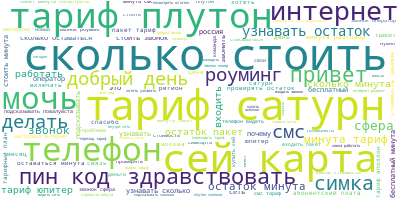

In [6]:
from wordcloud import WordCloud
long_string = " ".join(texts)
wordcloud = WordCloud(background_color="white", contour_width=6, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

We build out LDA model on counts of unigrams and bigrams.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, ngram_range = (1,2))
tfidf = tfidf_vectorizer.fit_transform(texts)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, ngram_range = (1,2))
tf = tf_vectorizer.fit_transform(texts)
tf_feature_names = tf_vectorizer.get_feature_names()

Let's plot most frequent terms in the dataset to get additional intuition.

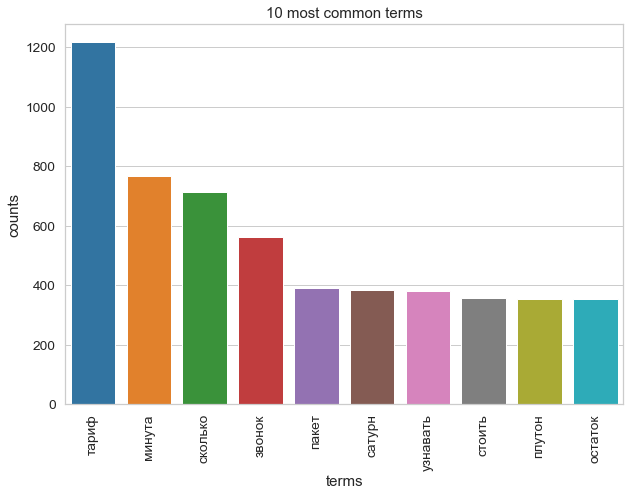

In [21]:
def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(10, 7))
    plt.subplot(title='10 most common terms')
    sns.barplot(x_pos, counts)
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('terms')
    plt.ylabel('counts')
    plt.show()

count_data = tf_vectorizer.fit_transform(texts)
plot_10_most_common_words(count_data, tf_vectorizer)

Now we fit LDA model.

In [23]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

no_topics = 4 # this parameter is determined by the experiments (see sections below)
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
lda = LatentDirichletAllocation(n_components=no_topics, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

Now let's classify out texts to the topic with the highest probability according to our model.

In [24]:
model = lda
predictions = model.transform(tf_vectorizer.transform(texts))
pred_labels = [pred.argmax() for pred in predictions]

We can plot corresponding sentenses for each topic and get some intuition about interpretation. E.g. following topic has something to do with issues about sim cards

In [27]:
data = pd.DataFrame(predictions)
data['label'] = pred_labels
data['original'] = lines
data['text'] = texts
data[data['label']==0].head()

,0,1,2,3,label,original,text
2,0.874340,0.042007,0.041677,0.041976,0,не могли бы вы мне пин напомнить?\n,мочь пин напоминать
3,0.904286,0.032695,0.031434,0.031585,0,"да, спасибо! а какой пин для настроек интернет...",спасибо пин настройка интернет
4,0.655757,0.050013,0.244035,0.050194,0,а откуда брать пин для телефона\n,откуда брать пин телефон
11,0.906111,0.031253,0.031254,0.031383,0,"у меня проблема с сим-картой, что делать??\n",проблема сей карта делать ??
12,0.890318,0.036631,0.036093,0.036958,0,Как понять что с симкартой? НЕ работает ничего\n,понимать симкарта работать ничто


Next we visualise classiffication counts.

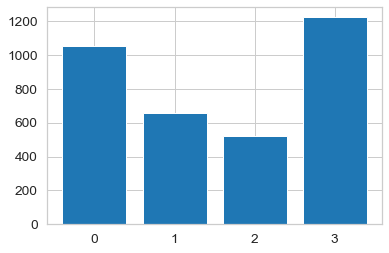

In [12]:
fig, ax = plt.subplots()
label_counts = [pred_labels.count(i) for i in range(no_topics)]
ax.bar(range(no_topics), label_counts)
ax.set_xticks(range(no_topics))

Now let's use pyLDAvis tool for visualisation of our topic modelling results. There we can see the words with the highest frequency for each topic and investigate intertopic distance. This will give us intuition for the final number of topics that we should use a model parameter.

In [25]:
%%time
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis
import os
LDAvis_prepared = sklearn_lda.prepare(model, tf, tf_vectorizer)

CPU times: user 3.83 s, sys: 104 ms, total: 3.94 s
Wall time: 1min 38s


/Users/home/anaconda/envs/fastai/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [26]:
pyLDAvis.enable_notebook()
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.077744 -0.016040       1        1  38.428070
0      0.320262  0.046642       2        1  26.377691
1     -0.074671 -0.228827       3        1  18.471454
2     -0.167847  0.198225       4        1  16.722785, topic_info=     Category         Freq              Term        Total  loglift  logprob
2258  Default   656.000000           сколько   656.000000  30.0000  30.0000
2442  Default   338.000000            стоить   338.000000  29.0000  29.0000
1380  Default   329.000000           остаток   329.000000  28.0000  28.0000
2292  Default   309.000000    сколько стоить   309.000000  27.0000  27.0000
1511  Default   313.000000               пин   313.000000  26.0000  26.0000
2519  Default  1105.000000             тариф  1105.000000  25.0000  25.0000
1440  Default   358.000000             пакет   358.000000  24.0000  24.0000
2199  Default   238.000000             симка   238.000000  23.0000  23.0000
624   Default   504.000000            звонок   504.000000  22.0000  22.0000
832   Default   320.000000             карта   320.000000  21.0000  21.0000
1011  Default   700.000000            минута   700.000000  20.0000  20.0000
876   Default   208.000000               код   208.000000  19.0000  19.0000
2672  Default   352.000000          узнавать   352.000000  18.0000  18.0000
2576  Default   316.000000           телефон   316.000000  17.0000  17.0000
1930  Default   201.000000          работать   201.000000  16.0000  16.0000
2153  Default   274.000000               сей   274.000000  15.0000  15.0000
2156  Default   253.000000         сей карта   253.000000  14.0000  14.0000
1519  Default   166.000000           пин код   166.000000  13.0000  13.0000
2683  Default   121.000000  узнавать остаток   121.000000  12.0000  12.0000
1386  Default   103.000000    остаток минута   103.000000  11.0000  11.0000
458   Default   141.000000            делать   141.000000  10.0000  10.0000
2483  Default   218.000000             сфера   218.000000   9.0000   9.0000
1582  Default   319.000000            плутон   319.000000   8.0000   8.0000
1363  Default   179.000000        оставаться   179.000000   7.0000   7.0000
1958  Default    87.000000          разговор    87.000000   6.0000   6.0000
348   Default   160.000000           входить   160.000000   5.0000   5.0000
1760  Default    87.000000        посмотреть    87.000000   4.0000   4.0000
2548  Default   229.000000      тариф плутон   229.000000   3.0000   3.0000
2551  Default   261.000000      тариф сатурн   261.000000   2.0000   2.0000
1388  Default    84.000000     остаток пакет    84.000000   1.0000   1.0000
...       ...          ...               ...          ...      ...      ...
978    Topic4    13.232671          мегабайт    13.942878   1.7361  -6.0432
2641   Topic4    12.651398         тп плутон    13.361856   1.7338  -6.0881
283    Topic4    12.638939    включать пакет    13.349917   1.7337  -6.0891
820    Topic4    14.476980               как    15.291969   1.7336  -5.9533
1502   Topic4    58.204380        переходить    61.552481   1.7325  -4.5619
344    Topic4    20.008019            вулкан    21.249732   1.7282  -5.6297
1846   Topic4    10.589356    привет сколько    11.288756   1.7244  -6.2660
1972   Topic4    10.176149    разговор тариф    10.872961   1.7222  -6.3058
1507   Topic4    30.682606  переходить тариф    32.834073   1.7206  -5.2022
2460   Topic4    10.622545    стоить роуминг    11.371754   1.7202  -6.2629
1731   Topic4    11.101981    поменять тариф    11.888651   1.7199  -6.2188
1493   Topic4    51.151853           переход    59.946235   1.6297  -4.6911
2638   Topic4    41.668531                тп    49.835880   1.6094  -4.8961
2258   Topic4   390.139352           сколько   656.541923   1.2679  -2.6594
277    Topic4    50.745407          включать    70.447082   1.4604  -4.6991
2704   Topic4    27.325192              уран    34.606264   1

From examining the results we can assume the following interpretations for the clusters:

1 - questions about the current conditions of the tarif of the user (price per minute)

2 - questions related to sim card and pin code

3 - questions about how much balance is currently left (calls, internet)

4 - questions about comparison between different tarifs

Note that correponding numbers of topics are shifted by 1 compared to our previous investigations

Finally we do t-SNE dimensionality reduction to see how well final clusters are separated from each other. High degree of separation corresponds to presumably more meaningful model.

In [29]:
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors

tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(predictions)

output_notebook()
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(no_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[pred_labels])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3450 samples in 0.002s...
[t-SNE] Computed neighbors for 3450 samples in 0.079s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3450
[t-SNE] Computed conditional probabilities for sample 2000 / 3450
[t-SNE] Computed conditional probabilities for sample 3000 / 3450
[t-SNE] Computed conditional probabilities for sample 3450 / 3450
[t-SNE] Mean sigma: 0.000514
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.464077
[t-SNE] KL divergence after 1000 iterations: 0.329254


Loading BokehJS ...

## Conclusion
Here I prepared a demo of how topic modelling using LDA can be applied for identifying clusters of user requests. The examination of identified clusters is preliminary and requires further accurate tweaking of parameters for precise identification of different user intentions. Other clustering techniques can be applied as well for comparison of identified clusters.